In [1]:
import os
import cv2
import glob
import random
import warnings
import numpy as np
import seaborn as sns
import tensorflow as tf
from imutils import paths
from itertools import cycle
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input

/home/sanjeev/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [56]:
#base_path = '/home/sanjeev/DL_Exp_Kajal/DL_Prasad_Exp/Microsoft_PoC/Plots/X.npy'' # Data Path 
base_path = '/home/sanjeev/DL_Exp_Malware/DL_Prasad_Exp/Microsoft_PoC/asm_images/'
img_list = glob.glob(os.path.join(base_path, '*/*.png'))

In [57]:
# classes in malimg data
categories = os.listdir(base_path)
labels = [i for i in range(len(categories))]
label_dict = dict(zip(categories, labels))

In [58]:
cur_dir = os.getcwd()
os.chdir(base_path)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family

for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
fam = []
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
        fam.append(list_fams[label])
    label += 1
num_classes = label

Label: 0	Family:           Gatak	Number of images: 1013
Label: 1	Family:    Kelihos_ver1	Number of images: 398
Label: 2	Family:    Kelihos_ver3	Number of images: 2942
Label: 3	Family:        Lollipop	Number of images: 2478
Label: 4	Family:  Obfuscator.ACY	Number of images: 1228
Label: 5	Family:          Ramnit	Number of images: 1541
Label: 6	Family:           Simda	Number of images: 42
Label: 7	Family:          Tracur	Number of images: 751
Label: 8	Family:           Vundo	Number of images: 475


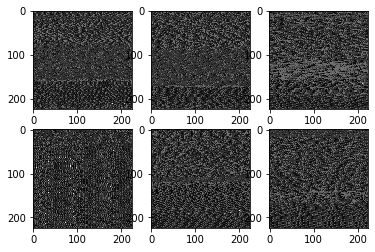

In [59]:
# Sample images from dataset
for i, img_path in enumerate(random.sample(img_list, 6)):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img, dtype=np.uint8)
    plt.subplot(2, 3, i+1)
    plt.imshow(img.squeeze())

In [60]:
# Using Mobile net V1 as base model for feature extraction 

In [61]:
bytes_features = np.load('/home/sanjeev/DL_Exp_Malware/DL_Prasad_Exp/Microsoft_PoC/Plots/MobileNetV1_feat_bytes_microsoft_1024.npy')
asm_features = np.load('/home/sanjeev/DL_Exp_Malware/DL_Prasad_Exp/Microsoft_PoC/Plots/MobileNetV1_feat_asm_microsoft_1024.npy')

In [62]:
bytes_features.shape, asm_features.shape

((10868, 1024), (10868, 1024))

In [63]:
X = []
for i in range(len(asm_features)):
    x = list(np.hstack((asm_features[i], bytes_features[i])))
    X.append(x)

In [64]:
X =  np.array(X)
X.shape

(10868, 2048)

## Classification using ET(Extrra Tree Classifier)

In [65]:
import pandas as pd
import disarray as da
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import ExtraTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix, matthews_corrcoef, roc_curve, auc

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.21, random_state=42)

In [67]:
print("X_Train:", X_train.shape)
print("Y_Train:", y_train.shape)
print("X_Test:", X_test.shape)
print("Y_Test:", y_test.shape)

X_Train: (8585, 2048)
Y_Train: (8585,)
X_Test: (2283, 2048)
Y_Test: (2283,)


In [68]:
# X_train = X_train // 255.0
# X_test = X_test // 255.0

In [69]:
%%time
clf=ExtraTreeClassifier()

CPU times: user 39 µs, sys: 7 µs, total: 46 µs
Wall time: 57.9 µs


In [70]:
%%time
clf.fit(X_train, y_train)   
print("Training Accuracy: ", round(clf.score(X_train, y_train)*100,3))

Training Accuracy:  100.0
CPU times: user 116 ms, sys: 63 µs, total: 116 ms
Wall time: 114 ms


In [ ]:
print("Testing Accuracy:", round((clf.score(X_test, y_test) * 100), 2))

In [72]:
%%time
y_pred = clf.predict(X_test)

CPU times: user 11 ms, sys: 0 ns, total: 11 ms
Wall time: 9.7 ms


In [73]:
%%time
ls = precision_recall_fscore_support(y_test, y_pred, average='micro')
print(int(round(ls[0]*100, 0)), int(round(ls[1]*100, 0)), int(round(ls[2]*100, 0)))

82 82 82
CPU times: user 8.66 ms, sys: 121 µs, total: 8.78 ms
Wall time: 7.08 ms


In [74]:
accuracy_score(y_pred,y_test)
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

         0.0       0.78      0.78      0.78       220
         1.0       0.85      0.90      0.87        77
         2.0       0.99      0.99      0.99       623
         3.0       0.79      0.79      0.79       505
         4.0       0.86      0.80      0.83       261
         5.0       0.63      0.67      0.65       313
         6.0       0.29      0.29      0.29         7
         7.0       0.60      0.59      0.59       158
         8.0       0.84      0.79      0.81       119

    accuracy                           0.82      2283
   macro avg       0.74      0.73      0.73      2283
weighted avg       0.82      0.82      0.82      2283



In [75]:
%%time
# Perform cross-validation and grid search to find the best hyperparameters
param_grid = {'random_state': [31],
              'max_depth': [None, 2, 4, 6],
              'min_samples_split': [2, 4, 6, 8],
              'min_samples_leaf': [1, 2, 3, 4]
             }

CPU times: user 12 µs, sys: 2 µs, total: 14 µs
Wall time: 23.4 µs


In [76]:
%%time
# Perform cross-validation and grid search to find the best hyperparameters
gs = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')
gs.fit(X_train, y_train)
# print(clf.get_params().keys())

CPU times: user 17.8 s, sys: 6.67 s, total: 24.4 s
Wall time: 24.4 s


GridSearchCV(cv=5, estimator=ExtraTreeClassifier(),
             param_grid={'max_depth': [None, 2, 4, 6],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [2, 4, 6, 8],
                         'random_state': [31]},
             scoring='accuracy')

In [77]:
print("Best hyperparameters:", gs.best_params_)

Best hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 4, 'random_state': 31}


In [78]:
%%time
print("Accuracy on testing set: {:.4f}".format(gs.score(X_test, y_test)))

Accuracy on testing set: 0.8055
CPU times: user 6.43 ms, sys: 7.65 ms, total: 14.1 ms
Wall time: 13.7 ms


In [79]:
y_pred = gs.predict(X_test)
print("Classification report:\n", classification_report(y_test, y_pred))

Classification report:
               precision    recall  f1-score   support

         0.0       0.78      0.85      0.81       219
         1.0       0.84      0.84      0.84        81
         2.0       0.99      0.99      0.99       624
         3.0       0.75      0.80      0.77       507
         4.0       0.80      0.84      0.82       245
         5.0       0.64      0.56      0.60       332
         6.0       0.17      0.14      0.15         7
         7.0       0.55      0.49      0.52       156
         8.0       0.89      0.83      0.86       112

    accuracy                           0.81      2283
   macro avg       0.71      0.70      0.71      2283
weighted avg       0.80      0.81      0.80      2283



In [80]:
list_fams = sorted(label_dict.keys())

In [81]:
classification_metrices = metrics.classification_report(y_test, y_pred, output_dict=True, target_names= list_fams)
df = pd.DataFrame(classification_metrices).transpose()
#df.to_csv('/home/sanjeev/DL_Exp_Kajal/DL_Prasad_Exp/Microsoft_PoC/Experiment_2/asm_plots/MobileNetV1_ET_asm.csv')

Plotting the confusion matrix


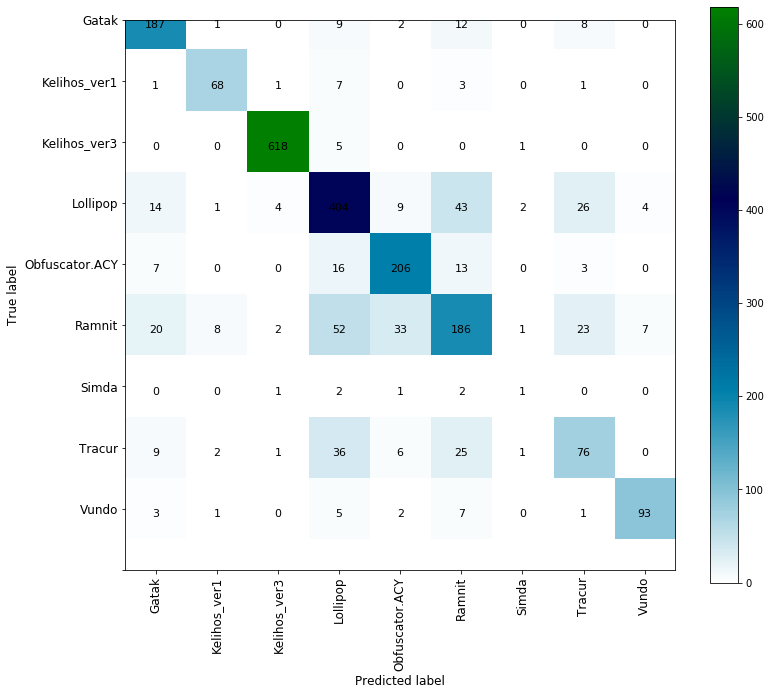

In [82]:
conf_matrix = confusion_matrix(y_test, y_pred)

print("Plotting the confusion matrix")
conf_mat = np.around(conf_matrix, decimals=2)  
figure = plt.gcf()
figure.set_size_inches(11, 10)
plt.imshow(conf_mat, interpolation='nearest', cmap='ocean_r')

for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(conf_mat[row][col]), xy=(col,row), ha='center', va='top', fontsize=11)
        
plt.xticks(range(len(list_fams)), list_fams, rotation=90, fontsize=12)
plt.yticks(range(len(list_fams)+1), list_fams, fontsize=12)

plt.ylabel('True label', fontsize=12)
plt.xlabel('Predicted label', fontsize=12)

plt.tight_layout()
plt.colorbar()
#plt.savefig('/home/sanjeev/DL_Exp_Kajal/DL_Prasad_Exp/Microsoft_PoC/Experiment_2/asm_plots/MobileNetV1_ET_asm.eps', bbox_inches='tight')
#plt.savefig('/home/sanjeev/DL_Exp_Kajal/DL_Prasad_Exp/Microsoft_PoC/Experiment_2/asm_plots/MobileNetV1_ET_asm.png', bbox_inches='tight')

plt.show()

In [83]:
cm = confusion_matrix(y_test, y_pred)
df = pd.DataFrame(cm)

In [84]:
pd.set_option('display.max_columns', None)  # force to display any number of columns.

In [85]:
#calculating true positives, false positives, true negatives and false negatives from confusion matrix
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

In [86]:
FP, FN, TP, TN

(array([ 54,  13,   9, 132,  53, 105,   5,  62,  11]),
 array([ 32,  13,   6, 103,  39, 146,   6,  80,  19]),
 array([187,  68, 618, 404, 206, 186,   1,  76,  93]),
 array([2010, 2189, 1650, 1644, 1985, 1846, 2271, 2065, 2160]))

In [87]:
#calculating false_omission_rate
NPV = TN/(TN+FN)
FOR = 1-NPV
FOR

array([0.01567091, 0.00590372, 0.00362319, 0.05895821, 0.01926877,
       0.07329317, 0.00263505, 0.03729604, 0.0087196 ])

In [88]:
data = df.da.export_metrics(metrics_to_include=['true_positive_rate', 'true_negative_rate', 'false_positive_rate', 
                                              'false_negative_rate', 'false_discovery_rate'])

In [89]:
for num, fam in zip(range(25), list_fams):
    data.rename(columns={data.columns[num]:fam}, inplace=True)

data1 = data.drop(columns=['micro-average'])
data1 = data1.T
# data.drop(df.tail(1).index,inplace=True)

data1['false_omission_rate'] = list(FOR)

data1

,true_positive_rate,true_negative_rate,false_positive_rate,false_negative_rate,false_discovery_rate,false_omission_rate
Gatak,0.853881,0.973837,0.026163,0.146119,0.224066,0.015671
Kelihos_ver1,0.839506,0.994096,0.005904,0.160494,0.160494,0.005904
Kelihos_ver3,0.990385,0.994575,0.005425,0.009615,0.014354,0.003623
Lollipop,0.796844,0.925676,0.074324,0.203156,0.246269,0.058958
Obfuscator.ACY,0.840816,0.973994,0.026006,0.159184,0.204633,0.019269
Ramnit,0.560241,0.946181,0.053819,0.439759,0.360825,0.073293
Simda,0.142857,0.997803,0.002197,0.857143,0.833333,0.002635
Tracur,0.487179,0.970851,0.029149,0.512821,0.449275,0.037296
Vundo,0.830357,0.994933,0.005067,0.169643,0.105769,0.008720


In [90]:
for i in data1:
    print('Average of', i, '-->', round((np.average(data1[i])*100), 4))

Average of true_positive_rate --> 70.4674
Average of true_negative_rate --> 97.4661
Average of false_positive_rate --> 2.5339
Average of false_negative_rate --> 29.5326
Average of false_discovery_rate --> 28.878
Average of false_omission_rate --> 2.5041


In [91]:
#MCC value
print('MCC Score:', round(matthews_corrcoef(y_test, y_pred), 2))

MCC Score: 0.76


In [92]:
print("micro_precision :", metrics.precision_score(y_test, y_pred, average='micro'))
print("micro_recall :", metrics.recall_score(y_test, y_pred, average='micro'))
print("micro_f1_score :", metrics.f1_score(y_test, y_pred, average='micro'))

micro_precision : 0.8055190538764783
micro_recall : 0.8055190538764783
micro_f1_score : 0.8055190538764783


In [93]:
print("macro_precision :", metrics.precision_score(y_test, y_pred, average='macro'))
print("macro_recall :", metrics.recall_score(y_test, y_pred, average='macro'))
print("macro_f1_score :", metrics.f1_score(y_test, y_pred, average='macro'))

macro_precision : 0.7112201317525887
macro_recall : 0.7046741457224787
macro_f1_score : 0.7068647535365314


In [94]:
enc = OneHotEncoder()
enc.fit(y_train.reshape(-1, 1))  
y_test = enc.transform(y_test.reshape(-1, 1))
y_pred = enc.transform(y_pred.reshape(-1, 1))

In [95]:
y_test = y_test.toarray()
y_pred = y_pred.toarray()

In [96]:
n_classes = 9

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

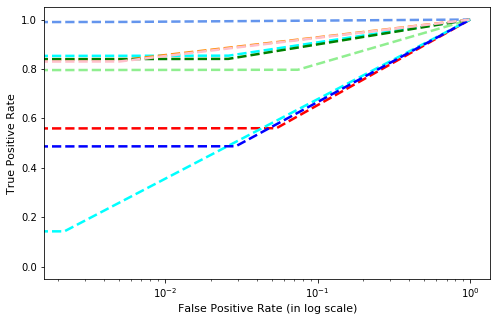

In [97]:
# Compute macro-average ROC curve and ROC area

n_classes = 9
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
lw = 2.5   # line width
plt.figure(figsize=(8,5))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'lightgreen', 'green', 'red', 'cyan', 'blue', 
                 'pink', 'purple', 'brown', 'coral', 'chocolate', 'indigo', 'navy'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, linestyle='dashed', lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.xscale("log")
plt.xlabel('False Positive Rate (in log scale)', fontsize=11)
plt.ylabel('True Positive Rate', fontsize=11)
#plt.savefig("/home/sanjeev/DL_Exp_Kajal/DL_Prasad_Exp/Microsoft_PoC/Experiment_2/asm_plots/MobileNetV1_ET_asm.eps", bbox_inches='tight')
#plt.savefig("/home/sanjeev/DL_Exp_Kajal/DL_Prasad_Exp/Microsoft_PoC/Experiment_2/asm_plots/MobileNetV1_ET_asm.png", bbox_inches='tight')

plt.show()